In [1]:
#Importamos las librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import grid_search_forecaster
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, mean_squared_error
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import joblib

# Procesamiento de Datos

In [2]:
#Cargamos los datos
alpha_betha = pd.read_csv('dataset_alpha_betha.csv')
to_predict = pd.read_csv('to_predict.csv')

In [3]:
alpha_betha.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   autoID            7043 non-null   object 
 1   SeniorCity        7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   Service1          7043 non-null   object 
 5   Service2          7043 non-null   object 
 6   Security          7043 non-null   object 
 7   OnlineBackup      7043 non-null   object 
 8   DeviceProtection  7043 non-null   object 
 9   TechSupport       7043 non-null   object 
 10  Contract          7043 non-null   object 
 11  PaperlessBilling  7043 non-null   object 
 12  PaymentMethod     7043 non-null   object 
 13  Charges           7043 non-null   float64
 14  Demand            7043 non-null   object 
 15  Class             7043 non-null   object 
dtypes: float64(1), int64(1), object(14)
memory

In [4]:
alpha_betha.head(5)

,autoID,SeniorCity,Partner,Dependents,Service1,Service2,Security,OnlineBackup,DeviceProtection,TechSupport,Contract,PaperlessBilling,PaymentMethod,Charges,Demand,Class
0,7590-VHVEG,0,Yes,No,No,No phone service,No,Yes,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,Alpha
1,5575-GNVDE,0,No,No,Yes,No,Yes,No,Yes,No,One year,No,Mailed check,56.95,1889.5,Alpha
2,3668-QPYBK,0,No,No,Yes,No,Yes,Yes,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Betha
3,7795-CFOCW,0,No,No,No,No phone service,Yes,No,Yes,Yes,One year,No,Bank transfer (automatic),42.30,1840.75,Alpha
4,9237-HQITU,0,No,No,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Betha


In [5]:
to_predict

,autoID,SeniorCity,Partner,Dependents,Service1,Service2,Security,OnlineBackup,DeviceProtection,TechSupport,Contract,PaperlessBilling,PaymentMethod,Charges,Demand,Class
0,9695-TERGH,0,No,No,Yes,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,96.05,NaN,NaN
1,5247-VRIOW,0,No,No,Yes,No,Yes,No,No,Yes,Month-to-month,No,Mailed check,53.45,NaN,NaN
2,5731-DDJUB,0,No,No,Yes,No,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),19.70,NaN,NaN


Text(0.5, 1.0, 'Conteo de registro según su clase')

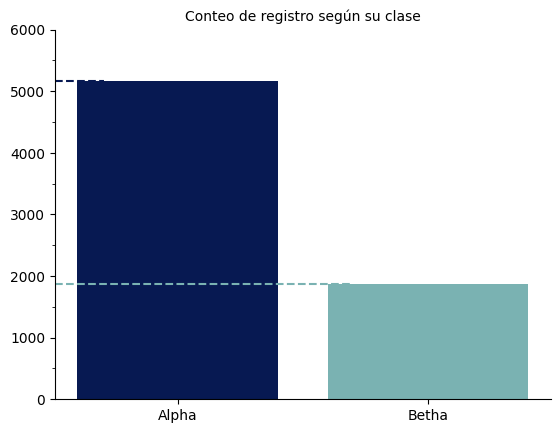

In [6]:
#Analizamos la cantidad de alpha y betha
alpha = alpha_betha[alpha_betha.Class == 'Alpha']
betha = alpha_betha[alpha_betha.Class == 'Betha']

x_bar = ['Alpha', 'Betha']
y_bar = [alpha['Class'].count(),
        betha['Class'].count()]
fig, ax = plt.subplots()
ax.bar(x = x_bar, height = y_bar, color = ['#071952','#7AB2B2'])
ax.tick_params(axis = 'both',labelcolor='#000000', labelsize = 10,)
ax.yaxis.set_major_locator(ticker.MultipleLocator(1000))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(500))
ax.set_ylim(0,6000)

ax.axhline(y = y_bar[0],xmax = .1, 
           ls = '--', color = '#071952')
ax.axhline(y = y_bar[1],xmax = .6, 
           ls = '--', color = '#7AB2B2')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title('Conteo de registro según su clase',size = 10)

In [7]:
alpha_betha

,autoID,SeniorCity,Partner,Dependents,Service1,Service2,Security,OnlineBackup,DeviceProtection,TechSupport,Contract,PaperlessBilling,PaymentMethod,Charges,Demand,Class
0,7590-VHVEG,0,Yes,No,No,No phone service,No,Yes,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,Alpha
1,5575-GNVDE,0,No,No,Yes,No,Yes,No,Yes,No,One year,No,Mailed check,56.95,1889.5,Alpha
2,3668-QPYBK,0,No,No,Yes,No,Yes,Yes,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Betha
3,7795-CFOCW,0,No,No,No,No phone service,Yes,No,Yes,Yes,One year,No,Bank transfer (automatic),42.30,1840.75,Alpha
4,9237-HQITU,0,No,No,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Betha
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,0,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,Alpha
7039,2234-XADUH,0,Yes,Yes,Yes,Yes,No,Yes,Yes,No,One year,Yes,Credit card (automatic),103.20,7362.9,Alpha
7040,4801-JZAZL,0,Yes,Yes,No,No phone service,Yes,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,Alpha
7041,8361-LTMKD,1,Yes,No,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Betha


In [9]:
#Procesamos y/o eliminamos columnas

#Eliminamos filas donde no hay valores Demand
alpha_betha = alpha_betha[alpha_betha.Demand != ' ']
alpha_betha['Demand'] = alpha_betha['Demand'].astype(float)

alpha_betha_new = alpha_betha.copy()
alpha_betha_new.drop(['autoID'], axis = 1, inplace=True)

label_encoders = {}
#Ajustamos y transformamos los datos
#alpha_betha_new = alpha_betha_new.apply(label_encoder.fit_transform)
# Entrenar y transformar el conjunto de entrenamiento
for column in alpha_betha_new.columns:
    #Inicializamos el LabelEncoder
    label_encoder = LabelEncoder()
    alpha_betha_new[column] = label_encoder.fit_transform(alpha_betha_new[column])
    label_encoders[column] = label_encoder

In [28]:
#Gardamos el LabelEncoder
joblib.dump(label_encoders, 'LabelEncoder.pkl')

['LabelEncoder.pkl']

In [10]:
alpha_betha_new.head(5)

,SeniorCity,Partner,Dependents,Service1,Service2,Security,OnlineBackup,DeviceProtection,TechSupport,Contract,PaperlessBilling,PaymentMethod,Charges,Demand,Class
0,0,1,0,0,1,0,2,0,0,0,1,2,142,74,0
1,0,0,0,1,0,2,0,2,0,1,0,3,497,3624,0
2,0,0,0,1,0,2,2,0,0,0,1,3,435,536,1
3,0,0,0,0,1,2,0,2,2,1,0,0,266,3570,0
4,0,0,0,1,0,0,0,0,0,0,1,2,728,674,1


In [11]:
#Balanceamos los Datos
alpha = alpha_betha_new[alpha_betha_new['Class'] == 0]
betha = alpha_betha_new[alpha_betha_new['Class'] == 1]

#Aumentamos el numero de muestras de Betha
betha_resampled = resample(betha, replace=True, 
                           n_samples=len(alpha), random_state=42)

#Unimos los datos balanceados
balanced_dataset = pd.concat([alpha, betha_resampled])

In [12]:
balanced_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10326 entries, 0 to 5591
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   SeniorCity        10326 non-null  int64
 1   Partner           10326 non-null  int64
 2   Dependents        10326 non-null  int64
 3   Service1          10326 non-null  int64
 4   Service2          10326 non-null  int64
 5   Security          10326 non-null  int64
 6   OnlineBackup      10326 non-null  int64
 7   DeviceProtection  10326 non-null  int64
 8   TechSupport       10326 non-null  int64
 9   Contract          10326 non-null  int64
 10  PaperlessBilling  10326 non-null  int64
 11  PaymentMethod     10326 non-null  int64
 12  Charges           10326 non-null  int64
 13  Demand            10326 non-null  int64
 14  Class             10326 non-null  int64
dtypes: int64(15)
memory usage: 1.3 MB


In [13]:
#Escalamos las columnas Charge y Demand
scaler = StandardScaler()
Var_scaled = scaler.fit_transform(balanced_dataset[['Charges','Demand']])
#Agregamos los valores escalados al dataframe
balanced_dataset['Charges'] = Var_scaled[:,0]
balanced_dataset['Demand'] = Var_scaled[:,1]

#Obtenemos los datos de caracteristicas y lo que queremos predecir
X = balanced_dataset.drop(columns=['Class'])
y_class = balanced_dataset['Class']
y_demand = balanced_dataset['Demand']

In [14]:
X.head(5)

,SeniorCity,Partner,Dependents,Service1,Service2,Security,OnlineBackup,DeviceProtection,TechSupport,Contract,PaperlessBilling,PaymentMethod,Charges,Demand
0,0,1,0,0,1,0,2,0,0,0,1,2,-1.267690,-1.415507
1,0,0,0,1,0,2,0,2,0,1,0,3,-0.497964,0.395744
3,0,0,0,0,1,2,0,2,2,1,0,0,-0.998828,0.368193
6,0,0,1,1,2,0,2,0,0,0,1,1,0.753111,0.420745
7,0,0,0,0,1,2,0,0,0,0,0,3,-1.272026,-0.869070


In [15]:
#Separamos los datos para cada modelo
# X_train, X_test, y_train_demand, y_test_demand = train_test_split(X, y_demand, 
#                     test_size=0.2, random_state=42)
X_train, X_test, y_train_class, y_test_class = train_test_split(X, y_class, 
                    test_size=0.2, random_state=42)

In [16]:
print(f'El tamaño de Datos de Train es de {len(X_train)}')
print(f'El tamaño de Datos de Test es de {len(X_test)}')
print('-'*40)
print(f'El tamaño de Class Train es {len(y_train_class)}')
#print(f'El tamaño de Demand Train es {len(y_train_demand)}')
print(f'El tamaño de Class Test es {len(y_test_class)}')
#print(f'El tamaño de Demand Test es {len(y_test_demand)}')

El tamaño de Datos de Train es de 8260
El tamaño de Datos de Test es de 2066
----------------------------------------
El tamaño de Class Train es 8260
El tamaño de Class Test es 2066


# Configuracion del Modelo

### Modelo para Class

In [17]:
##Definimos modelo para Class
class_model = RandomForestClassifier(random_state=42)

#Grid de hiperparámetros 
param_grid_class = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]}

#Configuramos el GridSearchCV 
grid_search_class = GridSearchCV(
    estimator=class_model,
    param_grid=param_grid_class,
    scoring='accuracy',  # Queremos maximizar la exactitud
    cv=5,
    n_jobs=-1,
    verbose=2)


#Ejecutamos el grid search
grid_search_class.fit(X_train, y_train_class)

#Obtenemos los mejores parametros 
best_params_class = grid_search_class.best_params_
print('='*80)
print("Mejores hiperparámetros para la clasificación:", best_params_class)

#Usamos el mejor modelo 
best_ClassModel = grid_search_class.best_estimator_
y_pred_class = best_ClassModel.predict(X_test)

#Calculamos el accuracy
accuracy = accuracy_score(y_test_class, y_pred_class)
print(f"Accuracy para 'Class': {accuracy:.2f}")

Fitting 5 folds for each of 162 candidates, totalling 810 fits


[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.8s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.3s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.3s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.9s
[CV] END max_depth=None, max_

In [18]:
# Evaluamos el modelo de clasificación
class_report_text = classification_report(y_test_class, y_pred_class)

print("\nMétricas de Clasificación:\n", class_report_text)
print(f"\nExactitud de Clasificación:, {accuracy:.2f}")



Métricas de Clasificación:
               precision    recall  f1-score   support

           0       0.96      0.84      0.90      1064
           1       0.85      0.96      0.90      1002

    accuracy                           0.90      2066
   macro avg       0.90      0.90      0.90      2066
weighted avg       0.91      0.90      0.90      2066


Exactitud de Clasificación:, 0.90


### Procesamiento de datos a Predecir

In [19]:
to_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   autoID            3 non-null      object 
 1   SeniorCity        3 non-null      int64  
 2   Partner           3 non-null      object 
 3   Dependents        3 non-null      object 
 4   Service1          3 non-null      object 
 5   Service2          3 non-null      object 
 6   Security          3 non-null      object 
 7   OnlineBackup      3 non-null      object 
 8   DeviceProtection  3 non-null      object 
 9   TechSupport       3 non-null      object 
 10  Contract          3 non-null      object 
 11  PaperlessBilling  3 non-null      object 
 12  PaymentMethod     3 non-null      object 
 13  Charges           3 non-null      float64
 14  Demand            0 non-null      float64
 15  Class             0 non-null      float64
dtypes: float64(3), int64(1), object(12)
memory usage

In [20]:
#Cargamos los datos de Demand pronosticados
demand_forecast = pd.read_csv('demand_forecast.csv')

In [21]:
to_predict_new = to_predict.copy()
to_predict_new.drop(['autoID','Demand','Charges','Class'], axis = 1, inplace=True)
#Convertimos categorias a valores
for column in to_predict_new.columns:
    le = label_encoders[column]
    to_predict_new[column] = le.transform(to_predict_new[column])
#Agregamos a "to_predict" el Demand pronosticado
to_predict_new['Demand'] = demand_forecast.Demand.iloc[-3:].values
to_predict_new['Charges'] = to_predict['Charges']

Var_scaled_pred = scaler.fit_transform(to_predict_new[['Charges','Demand']])
#Agregamos los valores escalados al dataframe
to_predict_new['Charges'] = Var_scaled_pred[:,0]
to_predict_new['Demand'] = Var_scaled_pred[:,1]

In [22]:
# #Predecimos las clases y la demanda
predicted_class = best_ClassModel.predict(to_predict_new.values)
#predicted_demand = best_DemandModel.predict(to_predict_new.values)

to_predict_new['Class'] = predicted_class
#to_predict_new['Demand'] = predicted_demand

#Devolvemos a los datos originales 
to_predict_new['Class'][to_predict_new['Class'] == 0] = 'Alpha'
to_predict_new['Class'][to_predict_new['Class'] == 1] = 'Betha'
to_predict_new['Demand'] = demand_forecast.Demand.iloc[-3:].values

print("\nPredicciones para el conjunto 'to_predict':\n", 
      to_predict_new[['Class', 'Demand']])


Predicciones para el conjunto 'to_predict':
    Class       Demand
0  Alpha   883.869894
1  Alpha  1104.973562
2  Alpha  1393.664205


/home/jsanchezo/.local/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/tmp/ipykernel_10456/3560237515.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_predict_new['Class'][to_predict_new['Class'] == 0] = 'Alpha'


# Entregables

In [23]:
# Guardamos el modelo y las métricas
joblib.dump(best_ClassModel, 'model_class.pkl')
#joblib.dump(best_DemandModel, 'model_demand.joblib')

with open('metrics.txt', 'w') as f:
    f.write("Modelo de Clasificación: RandomForestClassifier\n")
    f.write(f"Datos de Entrenamiento: {len(X_train)}\n")
    f.write(f"Datos de Prueba: {len(X_test)}\n")
    f.write(f"Métricas de Clasificación:\n{class_report_text}\n")
    f.write(f"Exactitud de Clasificación: {accuracy}\n\n")
    f.write("Modelo de Regresión: RandomForestClassifier\n")
    #f.write(f"RMSE para la predicción de 'Demand': {rmse}\n")

# Guardamos las predicciones
to_predict_new.to_csv('to_predict_new.csv', index=False)